# Use case Schouwen Westkop Noord

## 1. Import functionality

In [1]:
from functions import *

def draught(T_max, T_emp):
    return lambda x: interpolate(x, T_max, T_emp)

import pandas as pd
import VOcore

## 3. User defined values

In [2]:
start = [3.67670012, 51.70969009]                     # Location of the koppelpunt                             (lon, lat)
stop = [3.522637481591586,51.76880095558772]          # Location of the dredging area                          (lon, lat)
Volume = 300_500                                       # Total volume to be dregded                             (m^3)

ukc = 1.0                                             # Under Keel clearance                                   (m)
WWL = 20                                              # Width on Water Line                                    (m)
LWL = 80                                              # Length on Water Line                                   (m)
hopper_capacity = 1000                                # Maximal capacity of the hopper                         (m^3)
V_full = 10*0.514444444                               # Velocity in deep water when maximal loaded             (m/s)
V_emp = 12*0.514444444                                # Maximal sailing velocity empty in deep water           (m/s)
T_full = 6.6                                          # Draft when maximal Loaded                              (m)
T_emp = 4.5                                           # Draft When empty                                       (m)
WVPI_full = 10000                                     # Weight when maximal loaded                             (tf)
WVPI_empt = 4000                                      # Weight empty                                           (tf)


Q_velo = compute_v_provider(V_emp, V_full)            # Vessel velocity is dependent on load factor
Q_loading = compute_loading(1.5)                        # Vessel loading time is dependent on load factor
Q_unloading = compute_unloading(1.5)                  # Vessel unloading time is dependent on load factor


service_hours = 168                                   # hours per week
delay_for_bunkering = 10                               # hours per week
technical_delay = 10                                   # hours per week
project_related_delay = 3                             # hours per week

In [3]:
route = np.loadtxt('route.csv')
V_full = halem.Functions.Squat(route[:,2], T_full, V_full, LWL, WWL, ukc, WVPI_full).mean()
V_emp = halem.Functions.Squat(route[:,2], T_emp, V_emp, LWL, WWL, ukc, WVPI_full).mean()

D_func = draught(T_full, T_emp)
waves = [0, 5]
UKC = [ukc, ukc]

In [4]:
V_full, V_emp , halem.Functions.Squat(route[:,2], T_full, V_full, LWL, WWL, ukc, WVPI_full)

(4.249479614744241,
 5.438402143173487,
 array([3.5837317 , 3.44325928, 3.5903593 , 3.57016499, 3.41571652,
        3.31127275, 3.36064779, 3.34867586, 3.08027308, 3.24357824,
        3.17628025, 3.14012852, 2.98141978, 2.88150367, 3.8266419 ,
        4.01027575, 3.92553213, 3.80765239, 3.56422018, 3.40894876,
        3.56422018, 3.55718297, 3.59688581, 3.62027519, 3.39655578,
        3.51029845, 3.54172458, 3.63571836, 3.51807681, 3.30643456,
        3.41301934, 4.00970461, 4.05060376, 4.01272562]))

In [5]:
df = pd.read_pickle('test')

df.head()

,Tide [m],Hm0 [m],Tp [s],Water depth
2018-05-09 23:00:00,0.383292,0.0,0.0,8.243292
2018-05-10 00:00:00,-0.187545,0.0,0.0,7.672455
2018-05-10 01:00:00,-0.716728,0.0,0.0,7.143272
2018-05-10 02:00:00,-1.063555,0.0,0.0,6.796445
2018-05-10 03:00:00,-1.249519,0.0,0.0,6.610481


## 4. Digital-twin simulation

In [6]:
start_time_tot = time.time()
t0 = '10/05/2018 00:00:00'
d = datetime.datetime.strptime(t0, "%d/%m/%Y %H:%M:%S")
t0 = d.timestamp()
simulation_start = datetime.datetime.fromtimestamp(t0)
my_env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
my_env.epoch = time.mktime(simulation_start.timetuple())


TransportProcessingResource = type('TransportProcessingResource', 
                                   (core.Identifiable,              # Give it a name
                                    core.Log,                       # Allow logging of all discrete events
                                    core.ContainerDependentMovable, # A moving container, so capacity and location
                                    core.Processor,                 # Allow for loading and unloading
                                    core.HasResource,               # Add information on serving equipment
                                    core.Routeable,
                                    core.HasDepthRestriction,
                                   ),                 # Initialize spill terms
                                   {})
data_from_site = {"env": my_env,                  # The simpy environment defined in the first cel
                  "name": "Winlocatie",           # The name of the site
                  "geometry": [],                 # The coordinates of the project site
                  "capacity": Volume,            # The capacity of the site
                  "level": Volume,
                  "dataframe": df
                 
                 }               # The actual volume of the site

data_node = {"env": my_env,                      # The simpy environment defined in the first cel
                 "name": "Intermediate site",     # The name of the site
                 "geometry": []}                  # The coordinates of the project site

data_to_site = {"env": my_env,                    # The simpy environment defined in the first cel
                "name": "Dumplocatie",            # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": Volume,              # The capacity of the site
                "level": 0,
                "dataframe": df
               }                       # The actual volume of the site (empty of course)

route = np.loadtxt('route.csv')
route = route[:,:2]

path = np.zeros((len(route)+2,2))
path[0,:] = start
path[1:-1,:] = route
path[-1,:] = stop

#path = [start, stop]
Nodes, Edges = connect_sites_with_path(data_from_site, data_to_site, data_node, path)
positions = {}
FG = nx.Graph()
my_env.FG = FG

for node in Nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)
for edge in Edges:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

    
route = []
data_hopper = {"env": my_env,                                       # The simpy environment 
               "name": "Hopper 01",                                 # Name
               "geometry": Nodes[0].geometry,                       # It starts at the "from site"
               "loading_func": Q_loading,                           # Loading rate
               "unloading_func": Q_unloading,                       # Unloading rate
               "capacity": hopper_capacity,                         # Capacity of the hopper - "Beunvolume"
               "compute_v": Q_velo,                                 # Variable speed
               "route": route,
               "optimize_route": False,                              # Optimize the Route
               "optimization_type": 'time',                          # Optimize for the fastest path
               "compute_draught": D_func,
               "waves": waves,
               'ukc': UKC,
                'min_filling': 0,
                'max_filling': 50
              }

hopper = TransportProcessingResource(**data_hopper)

activity = model.Activity(env = my_env,             # The simpy environment defined in the first cel
                          name = "Soil movement",   # We are moving soil
                          origin = Nodes[0],        # We originate from the from_site
                          destination = Nodes[-1],  # And therefore travel to the to_site
                          loader = hopper,          # The benefit of a TSHD, all steps can be done
                          mover = hopper,           # The benefit of a TSHD, all steps can be done
                          unloader = hopper,        # The benefit of a TSHD, all steps can be done
                          start_event = None,       # We can start right away
                          stop_event = None)        # We stop once there is nothing more to move

my_env.run()
stop_time_tot = time.time()
computation_time_tot = stop_time_tot - start_time_tot
print("the Total computational time is:",int(computation_time_tot/60),'minutes and', np.round(computation_time_tot- int(computation_time_tot/60),2) , "sec")


Simulation cannot continue.
Simulation time exceeded the available metocean data.
the Total computational time is: 0 minutes and 12.16 sec


In [7]:
number_of_cycles = 0

for M in hopper.log['Message']:
    if M == 'loading start':
        number_of_cycles += 1
        
Operational_hours = service_hours - delay_for_bunkering - technical_delay - project_related_delay
efficiency = Operational_hours / service_hours
Total_production = Operational_hours/(((my_env.now - my_env.epoch)/ number_of_cycles/60) / 60) * (Volume / number_of_cycles)

vessels = [hopper]

activities = ['loading', 'unloading', 'sailing filled', 'sailing empty', 'waiting for tide']
colors = {0:'rgb(55,126,184)', 1:'rgb(255,150,0)', 2:'rgb(98, 192, 122)', 3:'rgb(98, 141, 122)', 4:'rgb(400, 150, 0)'}

Number of cycles 1168
Installation of dike finished in 66 days, 11:05:51
m^3 per uur 188.0
m^3 per week 31649.0
Avaraged volume per cycle 257.28
Avaraged minutes per cycle 81.94
Used load factors: {0.0, 0.5, 2.697378287, 3.559413845, 0.47, 4.181961709, 0.774007856, 0.44, 2.915728533, 5.981961709, 0.46, 0.445742132, 4.186080512, 2.359413845, 0.7740078549999999, 2.915728534, 0.031470386999999996, 0.45, 4.58540599}

Production included downtime [m3 / week]: 27316.51
improvement over old method: -56.14 %


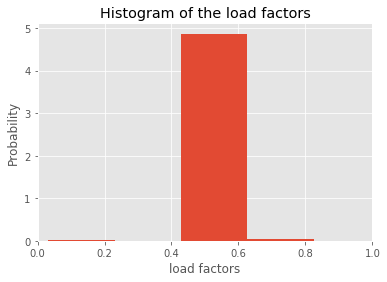

In [8]:
print('Number of cycles', number_of_cycles)
print("Installation of dike finished in {}".format(datetime.timedelta(seconds=int(my_env.now - my_env.epoch))))
print("m^3 per uur",np.round(Volume/(my_env.now - my_env.epoch) * 60 * 60))
print("m^3 per week",np.round(Volume/(my_env.now - my_env.epoch) * 60 * 60 * 7 * 24))   
print('Avaraged volume per cycle', np.round(Volume / number_of_cycles, 2))
print('Avaraged minutes per cycle', np.round((my_env.now - my_env.epoch)/ number_of_cycles/60, 2)) 
print('Used load factors:',set(np.array(hopper.log['Value'])/ hopper_capacity))
print()
print('Production included downtime [m3 / week]:',np.round(Total_production,2))
print('improvement over old method:', np.round((Total_production / 62278.78 - 1)*100 ,2), '%' )

VV = [hopper.log['Value'][0]]
for V in hopper.log['Value']:
    if V != VV[-1]:
        VV.append(V)
        
VV = np.array(VV)[np.array(VV) > 0]

plt.figure
ax = plt.subplot()
plt.hist(VV/ hopper_capacity, bins=30, density=True ) #, density=True)
plt.xlabel('load factors')
plt.ylabel('Probability')
plt.title('Histogram of the load factors')
plt.xlim(0, 1)
plt.show()

## 7. Postprocessing

In [9]:
plot.vessel_planning(vessels, activities, colors)

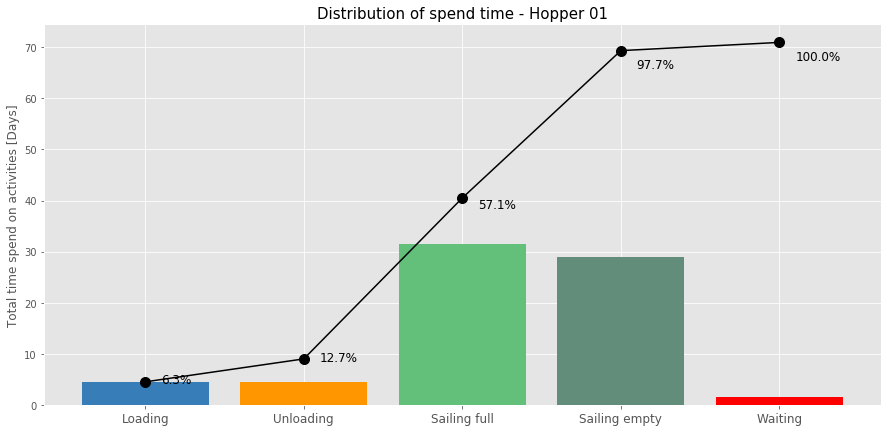

In [10]:
def activity_distribution(vessel, testing=False):
    activities = ["loading", "unloading", "sailing filled", "sailing empty", "waiting"]
    activities_times = [0, 0, 0, 0, 0]

    for i, activity in enumerate(activities):
        starts = []
        stops = []

        for j, message in enumerate(vessel.log["Message"]):
            if activity != "waiting":
                if message == activity + " start":
                    starts.append(vessel.log["Timestamp"][j])
                if message == activity + " stop":
                    stops.append(vessel.log["Timestamp"][j])
            else:
                if message[:7] == activity and message[-5:] == "start":
                    starts.append(vessel.log["Timestamp"][j])
                if message[:7] == activity and message[-4:] == "stop":
                    stops.append(vessel.log["Timestamp"][j])

        for j, _ in enumerate(starts):
            activities_times[i] += (stops[j] - starts[j]).total_seconds() / (3600 * 24)

    loading, unloading, sailing_full, sailing_empty, waiting = (
        activities_times[0],
        activities_times[1],
        activities_times[2],
        activities_times[3],
        activities_times[4],
    )

    # For the total plot
    fig, ax1 = plt.subplots(figsize=[15, 7])

    # For the barchart
    height = [loading, unloading, sailing_full, sailing_empty, waiting]
    labels = ["Loading", "Unloading", "Sailing full", "Sailing empty", "Waiting"]
    colors = [
        (55 / 255, 126 / 255, 184 / 255),
        (255 / 255, 150 / 255, 0 / 255),
        (98 / 255, 192 / 255, 122 / 255),
        (98 / 255, 141 / 255, 122 / 255),
        (255 / 255, 0 / 255, 0 / 255),
    ]

    positions = np.arange(len(labels))
    ax1.bar(positions, height, color=colors)

    # For the cumulative percentages
    total = sum([loading, unloading, sailing_full, sailing_empty, waiting])

    unloading += loading
    sailing_full += unloading
    sailing_empty += sailing_full
    waiting += sailing_empty
    y = [loading, unloading, sailing_full, sailing_empty, waiting]
    n = [
        loading / total,
        unloading / total,
        sailing_full / total,
        sailing_empty / total,
        waiting / total,
    ]

    ax1.plot(positions, y, "ko", markersize=10)
    ax1.plot(positions, y, "k")

    for i, txt in enumerate(n):
        x_txt = positions[i] + 0.1
        y_txt = y[i] * 0.95
        ax1.annotate("{:02.1f}%".format(txt * 100), (x_txt, y_txt), size=12)

    # Further markup
    plt.ylabel("Total time spend on activities [Days]", size=12)
    ax1.set_xticks(positions)
    ax1.set_xticklabels(labels, size=12)
    plt.title("Distribution of spend time - {}".format(vessel.name), size=15)

    if testing == False:
        plt.show()


activity_distribution(hopper, testing=False)

In [11]:
coords_WGS = np.loadtxt('D:/Use_case_Schouwen/baty_WGS.csv')
N = 200
x_r = np.arange(coords_WGS[:,0].min(), coords_WGS[:,0].max(), (coords_WGS[:,0].max() - coords_WGS[:,0].min())/N)
y_r = np.arange(coords_WGS[:,1].min(), coords_WGS[:,1].max(), (coords_WGS[:,1].max() - coords_WGS[:,1].min())/N)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = griddata(coords_WGS[:,:2], coords_WGS[:,2], (x_r, y_r), method= 'linear')

Hopper_route = hopper.log['Geometry']
x_loc = []
y_loc = []
for G in Hopper_route:
    x_loc.append(G.x)
    y_loc.append(G.y)
x_loc = np.array(x_loc)
y_loc = np.array(y_loc)

TT = hopper.log['Timestamp']
Time = []

for T in TT:
    TTT = T.timestamp()
    Time.append(TTT)

Time= np.array(Time)
Time = (Time - Time[0])/3600/24

points = np.array([x_loc, y_loc]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

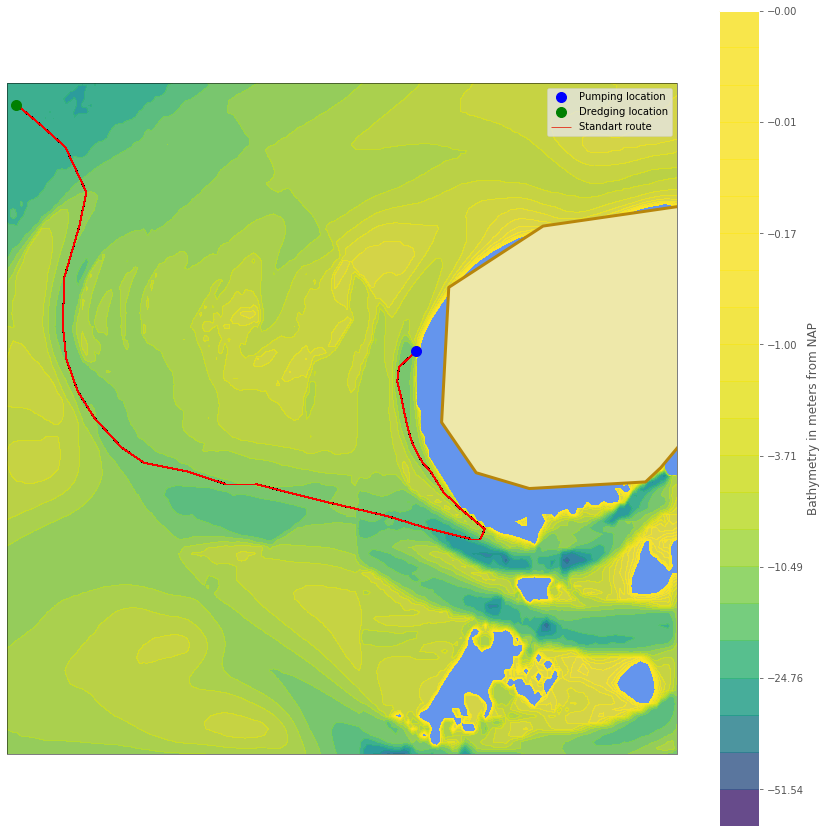

In [12]:
fig = plt.figure(figsize = (15,15))
ax = plt.subplot(projection=ccrs.Mercator())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m', edgecolor='face', facecolor='cornflowerblue', zorder = 0))

cval = np.arange (-2.3,0,0.1) ** 5
im = plt.contourf(x_r,y_r,WD_r,cval, alpha = 0.8, transform=ccrs.PlateCarree())
fig.colorbar(im, ax=ax, label = 'Bathymetry in meters from NAP')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)


norm = plt.Normalize(Time.min(), Time.max())
lc = LineCollection(segments, linewidth = 1, cmap='rainbow', norm=norm, transform=ccrs.PlateCarree(), label = 'Standart route')

lc.set_array(Time)
line = ax.add_collection(lc)

plt.plot(start[0], start[1],'bo',transform=ccrs.PlateCarree(), label =  'Pumping location', markersize = 10)
plt.plot(stop[0], stop[1], 'go',transform=ccrs.PlateCarree() , label = 'Dredging location', markersize = 10)

ax.set_extent([x_loc.min()*0.999, x_loc.max()*1.02, y_loc.min()*0.999, y_loc.max()*1.0001])
plt.legend(loc = 'best')

plt.show()

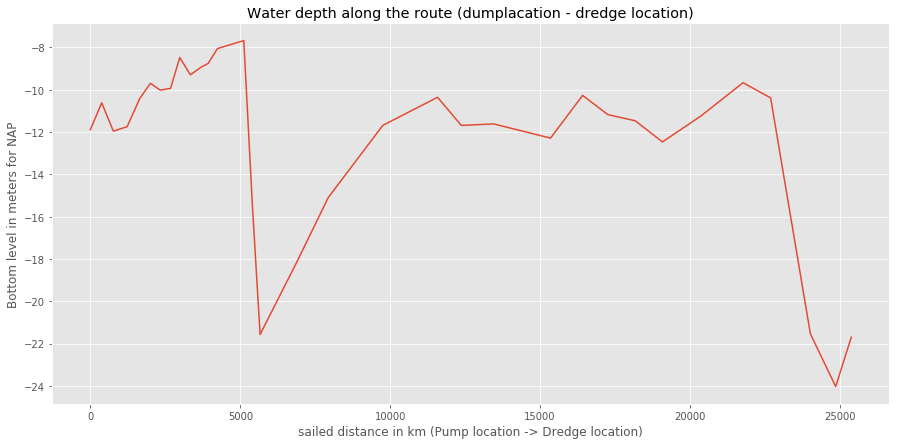

In [13]:
dist = [0]
route = np.loadtxt('route.csv')
D = 0
for i in range(1,len(route)):
    D = D + halem.Functions.haversine(route[i, :2][::-1] , route[i-1, :2][::-1])
    dist.append(D)
    
plt.figure(figsize=(15,7))
plt.plot(dist, -route[:,2])
plt.title('Water depth along the route (dumplacation - dredge location)')
plt.xlabel('sailed distance in km (Pump location -> Dredge location)')
plt.ylabel('Bottom level in meters for NAP')
plt.show()